In [115]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, \
    precision_recall_curve, log_loss

from sklearn.model_selection import GridSearchCV

In [116]:
df = pd.read_csv('data/bioresponse.csv')

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [118]:
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [119]:
[c for c in df.columns if not c[1:].isdigit()]

['Activity']

In [120]:
df.Activity.value_counts(dropna=False)

Activity
1    2034
0    1717
Name: count, dtype: int64

In [121]:
df.D1.describe()

count    3751.000000
mean        0.076948
std         0.079989
min         0.000000
25%         0.033300
50%         0.066700
75%         0.100000
max         1.000000
Name: D1, dtype: float64

Prepare data splits

In [122]:
train, leftover = train_test_split(df, test_size=0.36, random_state=42)

In [123]:
validate, test = train_test_split(leftover, test_size=0.5, random_state=42)

In [124]:
X_train = train.drop('Activity', axis=1)
y_train = train.Activity

In [125]:
X_test = validate.drop('Activity', axis=1)
y_test = validate.Activity

1

In [126]:
models = [DecisionTreeClassifier(max_depth=3, random_state=42),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42),
          RandomForestClassifier(n_estimators=150, random_state=42),
          ]

In [127]:
for model in models:
    model.fit(X_train, y_train)
    print(f"{model.__class__.__name__} (max depth {model.max_depth if model.max_depth else 'not limited'})")
    print('train accuracy:', model.score(X_train, y_train))
    print('test accuracy :', model.score(X_test, y_test))
    print('precision     :', precision_score(y_test, model.predict(X_test)))
    print('recall        :', recall_score(y_test, model.predict(X_test)))
    print('f1            :', f1_score(y_test, model.predict(X_test)))
    print('log_loss      :', log_loss(y_test, model.predict_proba(X_test)))
    print()

DecisionTreeClassifier (max depth 3)
train accuracy: 0.7729166666666667
test accuracy : 0.7733333333333333
precision     : 0.7712082262210797
recall        : 0.8241758241758241
f1            : 0.7968127490039841
log_loss      : 0.5171086794245594

DecisionTreeClassifier (max depth not limited)
train accuracy: 1.0
test accuracy : 0.7140740740740741
precision     : 0.7244094488188977
recall        : 0.7582417582417582
f1            : 0.7409395973154363
log_loss      : 10.30581496903646

RandomForestClassifier (max depth 3)
train accuracy: 0.7383333333333333
test accuracy : 0.7422222222222222
precision     : 0.7581521739130435
recall        : 0.7664835164835165
f1            : 0.7622950819672132
log_loss      : 0.5950600000874459

RandomForestClassifier (max depth not limited)
train accuracy: 1.0
test accuracy : 0.794074074074074
precision     : 0.8048780487804879
recall        : 0.8159340659340659
f1            : 0.810368349249659
log_loss      : 0.4633939875369518



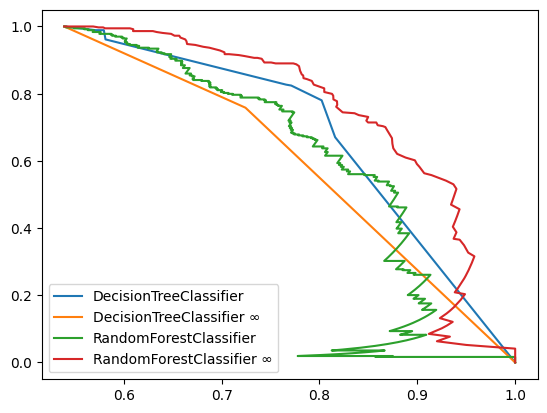

In [128]:
for model in models:
    prc = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(prc[0], prc[1])
    plt.legend([f'{name}{" ∞" * (i % 2)}' for i, name in list(enumerate([m.__class__.__name__ for m in models]))])

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])

(-0.05, 1.05)

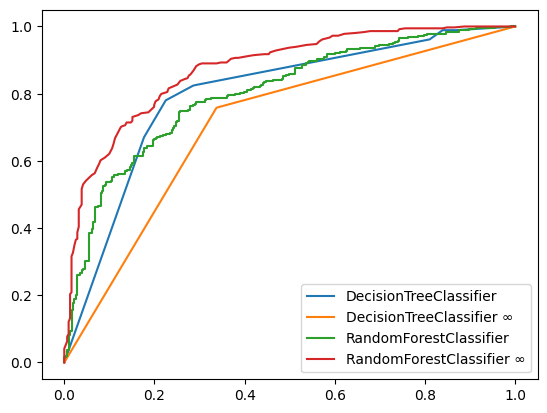

In [129]:
for model in models:
    roc = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(roc[0], roc[1])
    plt.legend([f'{name}{" ∞" * (i % 2)}' for i, name in list(enumerate([m.__class__.__name__ for m in models]))])

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

2. Train a max-recall classifier (avoid FN)

In [134]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)

In [146]:
param_grid = {
    'max_depth': [15, None],
    'max_features': [0.9, "sqrt"],
    # 'n_estimators': [150, 200]
}

In [147]:
grid_search = GridSearchCV(clf, param_grid, scoring='recall', cv=5, n_jobs=-1)

In [148]:
grid_search.fit(X_train, y_train);

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=150,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15, None],
                         'max_features': [0.9, 'sqrt']},
             scoring='recall')

In [149]:
grid_search.best_params_

{'max_depth': 15, 'max_features': 0.9}

In [150]:
grid_search.best_score_

0.8267306126142431

In [167]:
recall_score(y_train, clf.predict(X_train))

0.9891219891219891

In [168]:
recall_score(y_test, clf.predict(X_test))

0.8324175824175825

In [158]:
X_final = test.drop('Activity', axis=1)
y_final = test.Activity

In [169]:
recall_score(y_final, clf.predict(X_final))

0.7885117493472585

In [160]:
precision_score(y_final, clf.predict(X_final))

0.8053333333333333

In [161]:
recall_score(y_final, clf.predict(X_final))

0.7885117493472585

In [162]:
f1_score(y_final, clf.predict(X_final))

0.7968337730870714

In [172]:
log_loss(y_final, clf.predict_proba(X_final))

0.47139389378872043

In [170]:
for model in models:
    print(recall_score(y_final, model.predict(X_final)))

0.7859007832898173
0.741514360313316
0.7389033942558747
0.793733681462141


In [166]:
for model in models:
    try:
        print(model.get_depth())
    except:
        print(model.__class__.__name__)

3
29
RandomForestClassifier
RandomForestClassifier
